In [1]:
# Python
import itertools
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
from autots import AutoTS
import matplotlib.pyplot as plt 
import funciones
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

In [2]:
df_main = pd.read_excel("https://raw.githubusercontent.com/carrenogf/MCD-Series-Temporales/main/dataset/series_diarias.xlsx")
df_main = df_main.sort_values("FECHA",ascending=True)
df_main.set_index("FECHA", inplace=True)
df_copa = df_main["CHU_COPA_AJUST"].dropna()
df_recprop = df_main["CHU_REC_PROPIOS_AJUST"].dropna()
df_regal = df_main["CHU_REGALIAS_AJUST"].dropna()
dataframes = [df_copa, df_recprop, df_regal]
for i in range(len(dataframes)):
  dataframes[i] = dataframes[i].reindex(pd.date_range(start=dataframes[i].index.min(), end=dataframes[i].index.max(), freq='B'))
  dataframes[i] = dataframes[i].fillna(0)
    
titulos = ["CHU_COPA_AJUST", "CHU_REC_PROPIOS_AJUST", "CHU_REGALIAS_AJUST"]

In [3]:
# TRAIN TEST
n_train = 0.9
train_copa = dataframes[0].iloc[:round(len(dataframes[0])*n_train)]
test_copa = dataframes[0].iloc[round(len(dataframes[0])*n_train):]
print(f"Coparticipacion: train({train_copa.shape}), test({test_copa.shape})")

train_recursos = dataframes[1].iloc[:round(len(dataframes[1])*n_train)]
test_recursos = dataframes[1].iloc[round(len(dataframes[1])*n_train):]
print(f"Recursos: train({train_recursos.shape}), test({test_recursos.shape})")

train_regalias = dataframes[2].iloc[:round(len(dataframes[2])*n_train)]
test_regalias = dataframes[2].iloc[round(len(dataframes[2])*n_train):]
print(f"Regalias: train({train_regalias.shape}), test({test_regalias.shape})")

dataframes_train = [ train_copa, train_recursos, train_regalias ]
dataframes_test = [ test_copa, test_recursos, test_regalias ]

Coparticipacion: train((1584,)), test((176,))
Recursos: train((1995,)), test((222,))
Regalias: train((1985,)), test((221,))


In [ ]:
results_train_test = []
predictions_test = []
for i, df in enumerate(dataframes_train):
    df_train = df
    df_test = dataframes_test[i]
    
    model = AutoTS(
        forecast_length=len(dataframes_test[i]),
        frequency="B",
        prediction_interval=0.95,
        ensemble=None,
        models_mode='deep',
        model_list = 'superfast',
        max_generations=10,   # intenta optimizar el modelo a traves de 10 iteraciones de ajuste.
        num_validations=3,
        no_negatives=True,
        n_jobs='auto')
    modelAutoTS = model.fit(df_train)
    # Find the best parameters
    
    fechas = pd.date_range(start=df_test.index.min(), end=df_test.index.max(), freq='B')
    pred_test = model.predict(forecast_length=len(fechas)).forecast
    predictions_test.append(pred_test)
    # Cálculo del MSE en el conjunto de prueba
    mape_test = mean_absolute_percentage_error(df_test, pred_test)
    mape_mean = mean_absolute_percentage_error(df_test, [df_test.mean()] * len(df_test))
    mse_test = mean_squared_error(df_test, pred_test)
    mae_test = mean_absolute_error(df_test, pred_test)
    rmse = np.sqrt(mean_squared_error(df_test, pred_test))
    results_train_test.append({
        "model": modelAutoTS,
        "name": df_train.name,
        "len_train": len(df_train),
        "len_test": len(df_test),
        "mape_test": mape_test,
        "mse_test":mse_test,
        "mape_mean": mape_mean,
        "mae_test": mae_test,
        "rmse": rmse
    })



,model,name,len_train,len_test,mape_test,mse_test,mape_mean,mae_test,rmse
0,Initiated AutoTS object with best model: \nSea...,CHU_COPA_AJUST,1584,176,"1,069,270,913,042,505,662,464.00","13,915,584,464,387.94","758,549,686,672,395,206,656.00","2,832,338.77","3,730,359.83"
1,Initiated AutoTS object with best model: \nGLS...,CHU_REC_PROPIOS_AJUST,1995,222,"476,620,172,305,521,311,744.00","2,260,142,721,034.89","584,990,421,138,727,370,752.00","1,165,779.05","1,503,377.11"
2,Initiated AutoTS object with best model: \nSea...,CHU_REGALIAS_AJUST,1985,221,"2,174,434,595,027,651,395,584.00","37,330,896,462,977.80","5,891,392,032,994,430,550,016.00","2,100,315.90","6,109,901.51"


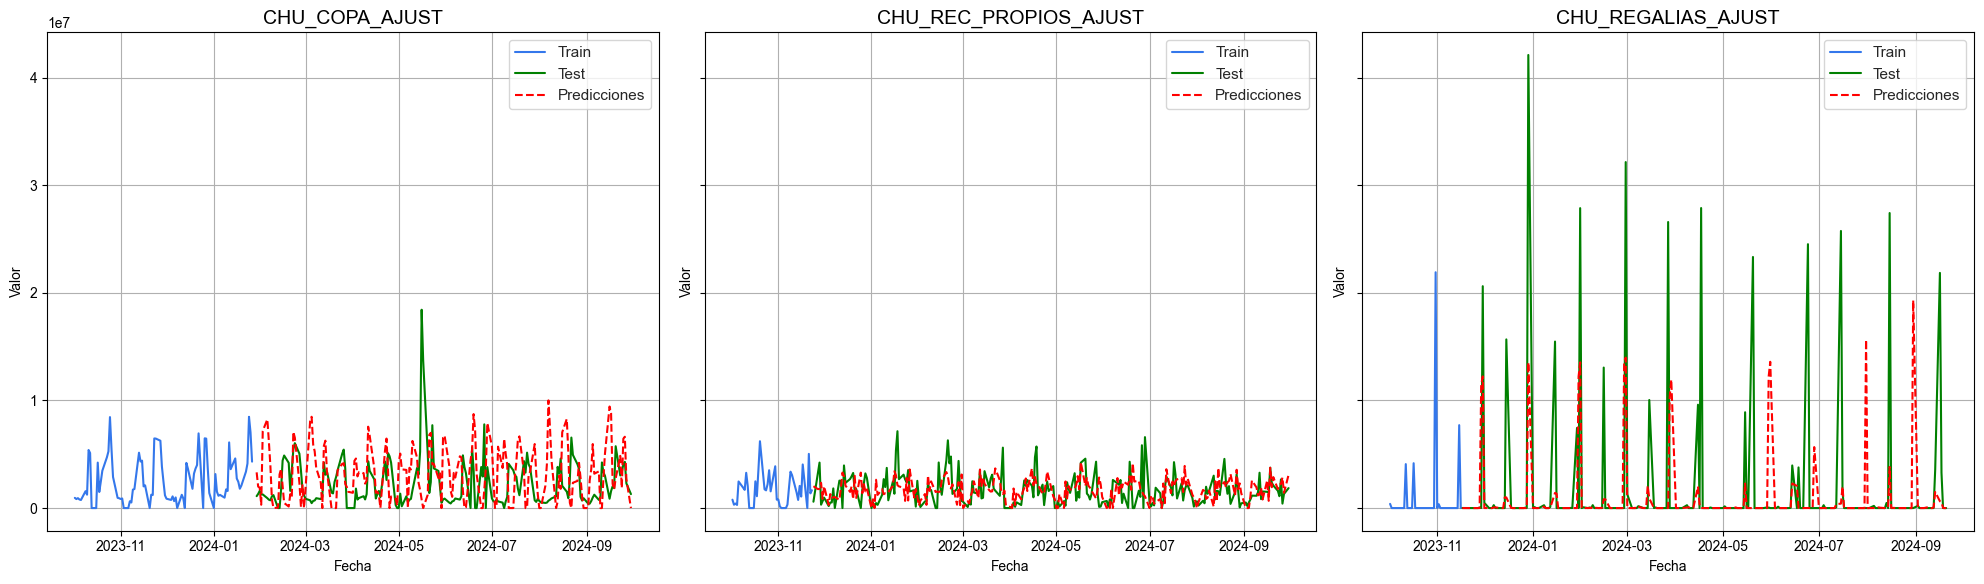

None

In [5]:
pd.options.display.float_format = '{:,.2f}'.format
display(pd.DataFrame(results_train_test))

display(funciones.plot_train_test_predictions(
    dataframes_train=dataframes_train,
    dataframes_test=dataframes_test,
    predictions_test=predictions_test,
    series_names=titulos,
    start_date='2023-10-01'
))

In [6]:
results = pd.DataFrame(results_train_test)

for i, row in results.iterrows():
    display(row["name"])
    print(row.model)

'CHU_COPA_AJUST'

Initiated AutoTS object with best model: 
SeasonalNaive
{'fillna': 'pchip', 'transformations': {'0': 'SeasonalDifference', '1': 'MaxAbsScaler'}, 'transformation_params': {'0': {'lag_1': 7, 'method': 'LastValue'}, '1': {}}}
{'method': 'lastvalue', 'lag_1': 96, 'lag_2': 28}
Validation: 0, 1, 2, 3
SMAPE: nan, nan, nan, nan
MAE: 2822593.394881551, 2705886.889956714, 2266922.725699413, 2126160.779481562
SPL: 0.34733674670580267, 0.33363305331363236, 0.3567839576534018, 0.39804259609704773


'CHU_REC_PROPIOS_AJUST'

Initiated AutoTS object with best model: 
GLS
{'fillna': 'ffill', 'transformations': {'0': 'DatepartRegression', '1': 'HistoricValues', '2': 'SeasonalDifference'}, 'transformation_params': {'0': {'regression_model': {'model': 'ElasticNet', 'model_params': {'l1_ratio': 0.1, 'fit_intercept': True, 'selection': 'cyclic'}}, 'datepart_method': 'simple_2', 'polynomial_degree': 2, 'transform_dict': {'fillna': None, 'transformations': {'0': 'ClipOutliers'}, 'transformation_params': {'0': {'method': 'clip', 'std_threshold': 4}}}, 'holiday_countries_used': False, 'lags': None, 'forward_lags': None}, '1': {'window': 730}, '2': {'lag_1': 24, 'method': 2}}}
{}
Validation: 0, 1, 2, 3
SMAPE: nan, nan, nan, nan
MAE: 1226828.4737256807, 958627.634529741, 872269.9874219908, 777486.4746628217
SPL: 0.2207936109057398, 0.20243127261189903, 0.1972549963009233, 0.17844552344385997


'CHU_REGALIAS_AJUST'

Initiated AutoTS object with best model: 
SeasonalityMotif
{'fillna': 'pchip', 'transformations': {'0': 'PositiveShift', '1': 'HistoricValues'}, 'transformation_params': {'0': {}, '1': {'window': None}}}
{'window': 10, 'point_method': 'midhinge', 'distance_metric': 'minkowski', 'k': 10, 'datepart_method': 'recurring', 'independent': True}
Validation: 0, 1, 2, 3
SMAPE: nan, nan, nan, nan
MAE: 1399081.8144796381, 1430369.8235294118, 1441480.6425339365, 1386704.180995475
SPL: 0.13252659123779703, 0.11893795878406024, 0.09366669094475673, 0.20322019724881865
